# Test Treatments A & B

This is the analysis of Treatment A & B for the novo case for presentation on 2022-03-28 @ 13.00



By Martin Siemienski Andersen



# Programs used

- ONLYOFFICE Spreadsheet
 
- Jupyter Notebook

- Pandas
    - Library for working with data sets.
    - Analyzing, cleaning, exploring, and manipulating data.
    
        

In [1]:
'''
This section will simply import the necessary modules to run the program. 
These are all standard Python modules, so nothing strange should happen here.
PLEASE have internet! 
'''
import sys
# Install modules, if not already installed, we could make this quiet, but it doesnt really matter
!{sys.executable} -m ensurepip
!{sys.executable} -m pip install numpy pandas matplotlib statistics openpyxl scipy nodejs tabulate seaborn
!{sys.executable} -m pip install openpyxl scipy nodejs tabulate seaborn statsmodels
print('prereq modules installed')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import re
from IPython.display import HTML
import seaborn as sns
import statsmodels.api as sm

print('imported modules')

Looking in links: c:\Users\nurrix\AppData\Local\Temp\tmpm6_tl8ap
prereq modules installed
imported modules


In [2]:
MASTER_XLSX_NAME : str = 'src/data.xlsx'

# Open MASTER dataframe
ADSLdf : pd.DataFrame = pd.read_excel(MASTER_XLSX_NAME, sheet_name='ADSL')
ADLBdf : pd.DataFrame = pd.read_excel(MASTER_XLSX_NAME, sheet_name='ADLB')

# Work Process

This section entails my thought process during cleanup of data. 

1. Know your data
2. Identify issues
3. Clean data (fix the issues)
4. Merge data
5. Analyze data
6. Visualize data

# Know your data

- The Raw data
- Visualize it
- Understand / Grasp it

In [3]:
print('## ADSL head')
ADSLdf.head().style.format(precision=1)

## ADSL head


,SUBJID,AGE,AGEU,FASFL,SAFFL,TRT01P,HGTBL,HGTBLU,WGTBL,WGTBLU,DIABDUR,DIABDURU
0,S001011,72,YEARS,Y,Y,Treatment B,1.7,m,224.0,lb,8.0,years
1,S001013,74,YEARS,Y,Y,Treatment A,1.6,m,187.0,lb,22.0,years
2,S001016,65,YEARS,Y,Y,Treatment B,1.7,m,70.7,kg,20.0,years
3,S001017,46,YEARS,Y,Y,Treatment B,1.8,m,123.9,kg,6.0,years
4,S001018,59,YEARS,Y,Y,Treatment A,1.8,m,70.9,kg,9.0,years


In [4]:
print('## ADLB head')
ADLBdf.head().style.format(precision=1)

## ADLB head


,SUBJID,FASFL,TRTP,AVISIT,VISITNUM,PARAM,PARAMCD,AVAL,AVALU,ANL01FL,ANL01REA
0,S001013,Y,Treatment A,Visit 10 (Week 0),10,Fasting plasma glucose (mmol/L),C105585P,7.4,mmol/L,Y,nan
1,S001013,Y,Treatment A,Visit 10 (Week 0),10,HbA1c Blood (%),C64849B,8.4,%,Y,nan
2,S001013,Y,Treatment A,Visit 14 (Week 4),14,HbA1c Blood (%),C64849B,7.0,%,Y,nan
3,S001013,Y,Treatment A,Visit 18 (Week 8),18,HbA1c Blood (%),C64849B,6.5,%,Y,nan
4,S001013,Y,Treatment A,Visit 22 (Week 12),22,HbA1c Blood (%),C64849B,6.4,%,Y,nan


# The data
- ADSL data recorded at baseline, 
- ADLB Repeated measurements recorded at the specified weeks, where baseline is week 0.

- Age, Height recorded at screening, not baseline


# Step 2: Identify Issues (Descriptives)

## ADSL
- Three subjects are missing DIABDUR. i.e. ADSL 
    - Line 16 (Subject S001047) Is missing entry at DIABDUR and DIABDURU.
- S005025 is 181 meters tall. 
    - Height[Height>100] = 0.01 * Height[Height>100]
- Weight is noted in both LB and KG, however, the table specifies KG, so we convert all lb to kg. i.e. for every row
    - Weight[Unit=='lb'] = Weight[Unit=='lb'] * 0.45
    

In [5]:
ADSLdf.describe(include='all').fillna('').transpose().style.format(precision=2)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
SUBJID,257,257,S001011,1,,,,,,,
AGE,257.00,,,,59.63,9.09,29.00,54.00,61.00,66.00,83.00
AGEU,257,1,YEARS,257,,,,,,,
FASFL,257,1,Y,257,,,,,,,
SAFFL,257,2,Y,254,,,,,,,
TRT01P,257,2,Treatment B,130,,,,,,,
HGTBL,257.00,,,,2.38,11.19,1.46,1.60,1.69,1.75,181.00
HGTBLU,257,1,m,257,,,,,,,
WGTBL,257.00,,,,148.44,58.95,56.10,93.40,148.00,194.00,325.00
WGTBLU,257,2,lb,144,,,,,,,


# Identify Issues (Descriptives)
## ADLB

- Verified that we only had Visits 10, 14, 18, 22, 26, 30, and the corresponding Week. 
    - Because we had a 181 m tall man (or woman)
- Verified PARAMCD values corresponded to FPG and HbA1c
- Verified that the units for FPG was mmol/L and HbA1c was %

- Found some dublicates.
    - dropping rows where ANL01FL is not 'Y' solved this.
        - 'Retest Rule' and 'oroginal visit realloc' ?
- Raw data descriptives : 
    - Subslide 1 = ADLB
    - Subslide 1 = ADLB for weeks

In [31]:
ADLBdf.describe(include='all').fillna('').rename({'50%':'median', 'count':'N'}, axis="index", level=0).transpose().style.format(precision=2)


,N,unique,top,freq,mean,std,min,25%,median,75%,max
SUBJID,2439,256,S081011,12,,,,,,,
FASFL,2439,1,Y,2439,,,,,,,
TRTP,2439,2,Treatment B,1230,,,,,,,
AVISIT,2439,7,Visit 10 (Week 0),510,,,,,,,
VISITNUM,2439.00,,,,22.30,9.27,10.00,14.00,22.00,30.00,36.00
PARAM,2439,2,HbA1c Blood (%),1701,,,,,,,
PARAMCD,2439,2,C64849B,1701,,,,,,,
AVAL,2439.00,,,,6.88,1.34,1.80,6.10,6.80,7.50,17.50
AVALU,2439,2,%,1701,,,,,,,
ANL01FL,2439,2,Y,2417,,,,,,,


In [7]:
ADLBdf.groupby(['AVISIT', 'PARAM']).describe(include='all').rename({'50%':'median', 'count':'N'}, axis="columns", level=1).fillna('')['AVAL'].style.format(precision=2)

# Clean data

## ADLB

- Converts Height to correct unit 
    - and if data was accidentally entered in cm instead of m
- Converts all Weights into Kg
- Diabetes Durations that are missing will be ignored.
    - Didnt do this, but you could easily enough check if DIABDUR>AGE, 
    - Should not be possible, but could entail DIABDURU==months

In [ ]:
def cnvHght(value:float, unit:str) -> float:
    """
    converts height from different unit (etc cm) to m.
    Also ensures that if height is < 100
    
    NOTE: only unit=='m' defined
    """
    
    if unit.lower() != 'm':
        return

    unit_conv = float(value<100) + float(value>=100) * 0.01
    return value * unit_conv

    

In [8]:
def cnvWgt2Kg(value:float, unit:str) -> float:
    """
    Converts weight into Kg
    - if lb -> wgt * fLB2KG
    else return wgt
    """
    fLB2KG = 0.4535924 # conversion ratio from lb to kg
    unit_conv = float(unit == 'lb') * fLB2KG + float(unit == 'kg')
    return value * unit_conv

def cnvMnths2Yrs(value:float, unit:str) -> float:
    """
    Convert months into years, if need be. (its not)
    """
    
    unit_conv = float(unit=='years' or unit=='years'.upper()) + float(unit=='months')*1.0/12.0
    return value * unit_conv

In [ ]:
def extWkVsts(value:str, task:str): 
    """ 
    Returns a list of data with the week numbers or visit number
    value: str [AVISIT row]
    task: str [extract 'visit'|'week' information]
    
    return value, depending on task
    """
    
    # ENUM should have been used here.
    
    # Find all numbers in 'AVISIT' (in the format : Visit 10 (Week 0) )
    
    
    nums = [int(i) for i in re.findall(r'\d+', value)]
    if task.lower() == 'visit':
        # first number always 'visit'
        return nums[0]
    if task.lower() == 'week':
        # second number always 'week'
        return nums[1]

In [9]:
def hndlADLBANL01FL(DF:pd.DataFrame) -> None:
    """
    Handles retest flag (I believe)
        DF: pd.DataFrame
        
    There are two types of notes
    'original visit realloc'
    'Retest rule'
    When 'original visit realloc' is there, we see a copy of it
    We can therefore safely ignore all rows with 'original visit realloc'. 
    However, for the retest rule, I am not sure if this is the valid entry, or if it is the other one.
    I will assume (this is a case study) that it is sufficient to handle it by dropping these rows for the analysis.
    This means we keep all rows, when ANL01FL=='Y', and drop when ANL01FL=='N'.
    """
    return DF[DF['ANL01FL']=='Y'].copy()
    

def chck4Dub(DF: pd.DataFrame, var_name: str) -> None:
    """ If a DF has dublicate Subjects, let us know"""
    SUBJID_dublicated = TableShell[TableShell.duplicated(['SUBJID'])]
    if len(SUBJID_dublicated):
        print(f"Number og dublicates in {var_name}: {len(SUBJID_dublicated)}")


In [33]:
def cleanADSL(DF:pd.DataFrame) -> pd.DataFrame:
    """ Returns cleaned data from ADSL dataframe
        DF: pd.DataFrame [ADSL dataframe]
         """
    
    # Add the fixed Columns
    fixed_list_in = ['SUBJID', 'TRT01P', 'FASFL', 'SAFFL', ]
    fixed_list_out = ['SUBJID', 'Treatment','FASFL', 'SAFFL', ]
    
    # define output data frame
    dfo = pd.DataFrame()
    dfo[fixed_list_out] = DF[fixed_list_in]
    
    dfo['AgeYears'] = DF.apply(lambda row: cnvMnths2Yrs(value=row.AGE, unit=row.AGEU), axis=1)
    dfo['HeightM'] = DF.apply(lambda row: cnvHght(value=row.HGTBL, unit=row.HGTBLU), axis=1)
    dfo['BodyWeightKg'] = DF.apply(lambda row: cnvWgt2Kg(value=row.WGTBL, unit=row.WGTBLU), axis=1)
    dfo['DiabetesDurationYears'] = DF.apply(lambda row: cnvMnths2Yrs(value=row.DIABDUR, unit=row.DIABDURU), axis=1)
    
    return dfo.copy()


In [11]:
def cleanADLB(DF:pd.DataFrame) -> pd.DataFrame:
    """ Cleans data in ADLB dataframe 
        DF: pd.DataFrame [ADLB dataframe]
        """
    dfo = pd.DataFrame()
    
    # Add the fixed Columns
    fixed_list_in = ['SUBJID', 'TRTP', 'VISITNUM','FASFL', 'ANL01FL', 'ANL01REA', 'PARAMCD', 'AVAL', 'AVALU']
    fixed_list_out = ['SUBJID', 'Treatment', 'VISITNUM', 'FASFL',  'ANL01FL', 'ANL01REA', 'PARAMCD', 'AVAL', 'AVALU']
    dfo[fixed_list_out] = DF[fixed_list_in]
    
    # Now put week-number AVISIT into Week
    dfo['Week'] = DF.apply(lambda row: extWkVsts(value=row.AVISIT, task='week'), axis=1)
    
    # Handles subject test duplication issue
    dfo = hndlADLBANL01FL(DF=dfo)
    
    return dfo.copy()


In [12]:
# Clean Data
ADSL_clean : pd.DataFrame = cleanADSL(DF = ADSLdf) 
ADLB_clean : pd.DataFrame = cleanADLB(DF = ADLBdf)        

# Merge Data

- ADSL data recorded at baseline, 
- ADLB Repeated measurements recorded at the specified weeks, where baseline is week 0.
- Include the following datacolumns
    - [Age, Height, Body Weight, Duration of Diabetes, HbA1c @ week 0 from ADLB]
- FASFL="Y"
- Acquire data from ADLB @ Week 0




In [13]:
# This contains some functions for creating baseline tables
def createBaselineADLB(DF: pd.DataFrame):
    """ Generate baseline ADLB table 
        Required:
            DF: pd.DataFrame [ADLB dataframe]
        Output:
            
    """
    
    # filters for ADLB
    one = DF['PARAMCD']=='C64849B'
    two = DF['VISITNUM']==10
    three = DF['ANL01FL']=='Y'
    four = DF['FASFL']=='Y'
    
    return DF[one & two & three & four].copy()


In [14]:
def getValueHbA1c(subject_name: str, ADLB: pd.DataFrame) -> float:
    """ 
    identify HbA1c values in ADLB with specific subject_name
    Required:
        subject_name: str [name of subject]
        ADLB: pd.DataFrame [ADLB dataframe]
    Output: 
        HbA value [float]
    """
    val =  ADLB[ADLB['SUBJID'] == subject_name].copy()['AVAL'].values
    # if val is not empty, return first datapoint
    if val.size>0:
        return val[0]

def populateTableShell(ADSL: pd.DataFrame, ADLB: pd.DataFrame) -> pd.DataFrame:
    """
    generate TableShell
    
    Requires: 
        ADSL : pd.DataFrame
        ADLB : pd.DataFrame
    Returns:
        TableShell: pd.DataFrame
    """
    dfo = pd.DataFrame()
    col_ADSL = ['SUBJID', 'Treatment', 'AgeYears', 'HeightM', 'BodyWeightKg', 'DiabetesDurationYears']
    col_tbl = ['SUBJID', 'Treatment', 'Age (yrs)','Height (m)', 'Body Weight (kg)', 'Duration of Diabetes (yrs)']
    dfo[col_tbl] = ADSL[col_ADSL].copy()
    
    # Base line ADLB
    ADLB_bl = createBaselineADLB(DF=ADLB).copy()
    
    # Identify subject specific HbA1c values
    dfo['HbA1c (%)'] = ADLB_bl.apply(lambda row: getValueHbA1c(subject_name=row.SUBJID, ADLB=ADLB_bl),axis=1)

    return dfo


In [15]:


TableShell = populateTableShell(ADSL=ADSL_clean, ADLB=ADLB_clean) 

# Check for dubl, this appears correct.
chck4Dub(DF=TableShell, var_name= 'TableShell')


ADSLdf['Total'] = 'Total'
numcount_groups = ADSLdf.groupby('TRT01P')['SUBJID'].count()
numcount_totals = ADSLdf.groupby('Total')['SUBJID'].count()
counts_df = pd.concat([numcount_groups,numcount_totals])

TableShell['Total'] = 'Total'
summary_groups = TableShell.groupby('Treatment').describe(include=np.number)
summary_total = TableShell.groupby('Total').describe(include=np.number)
summary_groups = pd.concat([summary_groups, summary_total]).transpose()


summary_groups.rename({'50%':'median', 'count':'N'}, axis="index", level=1, inplace=True)

incl_msrmnts = ['N', 'mean','std','median','min','max']
lvls2keep = summary_groups.index.get_level_values(1).isin(incl_msrmnts)
summary_groups = summary_groups[lvls2keep]


summary_groups = summary_groups.reindex(incl_msrmnts, level=1)


# Table 1 - Baseline and diabetes characteristics

- Correlation plot: Subslide 1


In [16]:
summary_groups.style.format(precision=2)


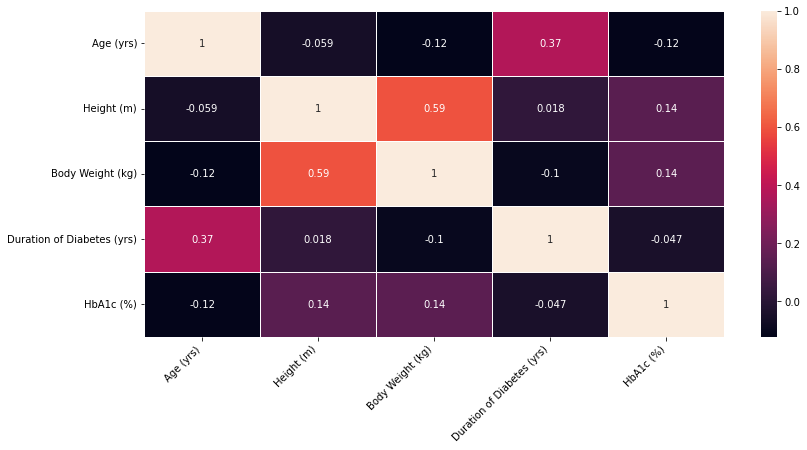

In [17]:

corrmat = TableShell.corr()
plt.figure(figsize=(13, 6))
sns.heatmap(corrmat, vmax=1, annot=True, linewidths=.5)
plt.xticks(rotation=45, ha='right')
plt.show()

In [18]:
counts_df.reset_index().transpose().style
counts_df.rename({'SUBJID':'Number of Subjects'},axis=0, inplace=True)
print(counts_df)

Treatment A    127
Treatment B    130
Total          257
Name: SUBJID, dtype: int64


In [25]:
def filtDADLB(DF, PARAMCD: str):
    """ Extract either Hb or FPG """
    # Filters
    f1 = DF['PARAMCD']==PARAMCD
    f2 = DF['FASFL']=='Y'
    f3 = DF['ANL01FL']=='Y'
    
    # Group data by Treatment and Week
    DF_out = DF[f1 & f2 & f3]
    return DF_out.copy()
    
def extMns(DF):
    """  """
    
    # Group data by Treatment and Week
    DF_out = DF.groupby(['Treatment','Week'], as_index=False).mean()
    DF_out['AVALstd'] = DF.groupby(['Treatment','Week'], as_index=False).std()['AVAL'] * 1.96
    DF_out['AVALskew'] = DF.groupby(['Treatment','Week'], as_index=False)['AVAL'].skew(axis='index')['AVAL']

    return DF_out.copy()

In [26]:
def pltFcn(ax, DF:pd.DataFrame,title:str, ylabel:str
           , with_baseline: bool
           , with_errorbars: bool = False
           , with_scatter:bool=False
           , with_skew:bool=False ):
    """ Generates plot of the 'AVAL' to figure """
    
    fig1_df = extMns(DF=DF)
    # Subplots
    #fig,ax = plt.subplots(figsize=[12,8])
    # If specified generate reference line (is hardcoded at Y=7.0)
    if with_scatter:
        for key,tmp_dataframe in DF.groupby('Treatment'):   
            ax.scatter(tmp_dataframe['Week'].apply(
                lambda v: v + np.random.uniform(-1, 1)), tmp_dataframe['AVAL']
                        , alpha=0.1)
    
    # Plot AVAL vs Week, grouped by Treatment
    for key,tmp_dataframe in fig1_df.groupby('Treatment'):
        # Plot the data
        if with_errorbars:
            ax.errorbar(x=tmp_dataframe['Week'], y=tmp_dataframe['AVAL'], 
                         yerr=tmp_dataframe['AVALstd'],label=key,
                        capsize=3)
        else:
            ax.errorbar(x=tmp_dataframe['Week'], y=tmp_dataframe['AVAL'],label=key)
            
        ax.plot(np.array([0.0,26.0]),np.array([7.0,7.0]), linestyle='dashed', color='gray')
    # Title and missing ylabel
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Week')
    ax.legend()

In [27]:
fig1_df = filtDADLB(DF=ADLB_clean, PARAMCD='C64849B')
fig2_df = filtDADLB(DF=ADLB_clean, PARAMCD='C105585P')

In [28]:
title = ['Mean plot of HbA1c (%) by time', 
        'Mean plot of FPG (mmMol/L) by time']
ylabel = ['HbA1c (%)', 'FPG (mMol/L)']



# Plot Figure 1 and 2

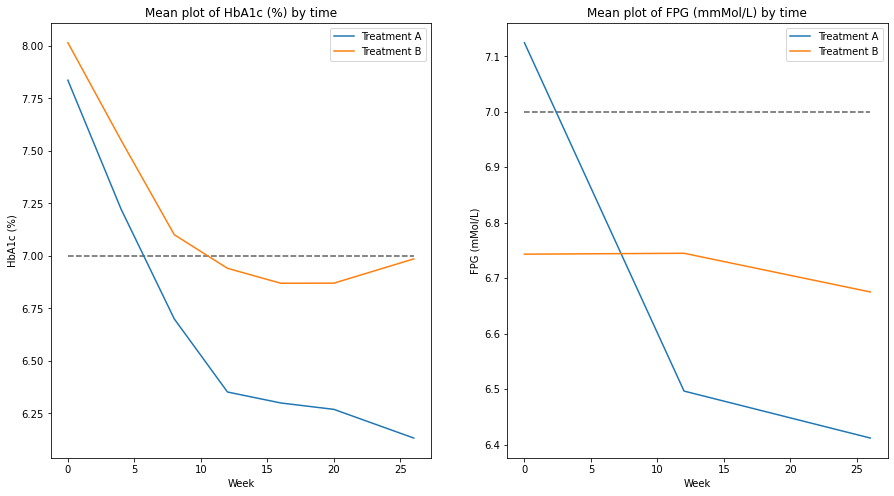

In [29]:
fig, ax = plt.subplots(1,2, figsize=[15,8])
pltFcn(ax[0], DF=fig1_df,title=title[0], ylabel=ylabel[0], with_baseline=True)
pltFcn(ax[1], DF=fig2_df,title=title[1], ylabel=ylabel[1], with_baseline=False)


# Same figure, but with more information

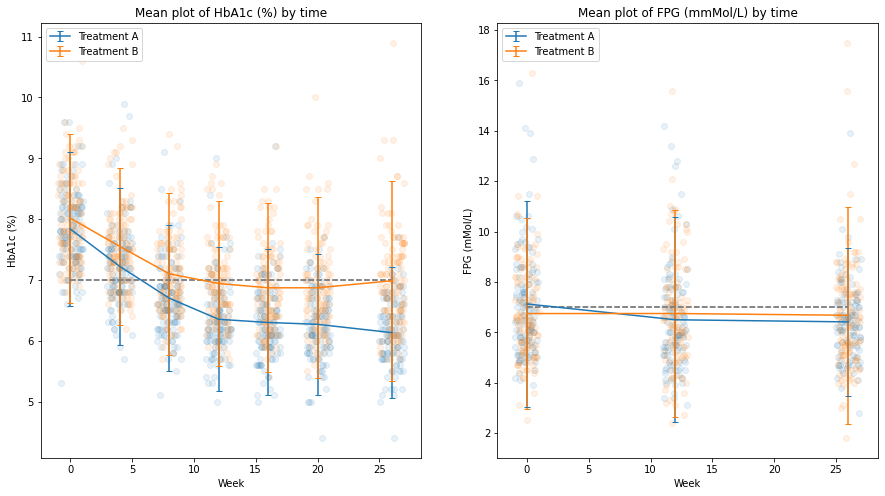

In [30]:
fig, ax = plt.subplots(1,2, figsize=[15,8])
pltFcn(ax[0], DF=fig1_df,title=title[0], ylabel=ylabel[0], with_baseline=True, with_errorbars=True, with_scatter=True)
pltFcn(ax[1], DF=fig2_df,title=title[1], ylabel=ylabel[1], with_baseline=False, with_errorbars=True, with_scatter=True)


# 